In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import awkward as ak
import os

In [2]:
# Directory path containing the ROOT files
directory_path = '/eos/purdue/store/user/lingqian/fullrun2_eft_minitrees/spinCorrInput_2016preVFP/Nominal'

# Define the specific files you want to include (with subdirectories)
desired_files = [
    'ee/ee_ttto2l2nu_jet_smeft_mtt_0to700_2016preVFP.root',
    'ee/ee_ttto2l2nu_jet_smeft_mtt_700to900_2016preVFP.root',
    'ee/ee_ttto2l2nu_jet_smeft_mtt_900toInf_2016preVFP.root',
    'mumu/mumu_ttto2l2nu_jet_smeft_mtt_0to700_2016preVFP.root',
    'mumu/mumu_ttto2l2nu_jet_smeft_mtt_700to900_2016preVFP.root',
    'mumu/mumu_ttto2l2nu_jet_smeft_mtt_900toInf_2016preVFP.root'
]

# Construct the full paths for the desired files
file_paths = [os.path.join(directory_path, filename) for filename in desired_files]

# Open each ROOT file and extract the 'ttBar_treeVariables_step8' TTree
trees = [uproot.open(file_path)['ttBar_treeVariables_step0'] for file_path in file_paths]

# Concatenate the TTrees from all files into a single TTree
file = uproot.concatenate(trees)

In [2]:
weight_sm=file['mgWeights'][:,200]


NameError: name 'file' is not defined

In [45]:
weightc152=file['mgWeights'][:,352]

In [1]:
weight_sm

NameError: name 'weight_sm' is not defined

In [17]:
import numpy as np

def predict_event_weight( c1, c2):
    """
    Predicts the event weight for given c1 and c2 values using least squares fitting.

    Parameters:
    weight (list of lists or numpy array): The event weight data.
    c1 (int or float): The value of c1 for prediction.
    c2 (int or float): The value of c2 for prediction.

    Returns:
    numpy array: Predicted event weights for each event at (c1, c2).
    """

    num_events = len(weight_sm)
    predicted = []

    for i in range(num_events):
        # Construct A matrix (per event)
        A = np.array([
            [1, 0, 0, 0, 0, 0],  # w_sm (c1=0, c2=0)
            [1, 1, 0, 1, 0, 0],  # w(c1=1, c2=0)
            [1, 0, 1, 0, 1, 0],  # w(c1=0, c2=1)
            [1, 1, 1, 1, 1, 1],  # w(c1=1, c2=1)
            [1, 2, 0, 4, 0, 0],  # w(c1=2, c2=0)
            [1, 0, 2, 0, 4, 0]   # w(c1=0, c2=2)
        ])

        # Construct w vector for this event
        w = np.array([
            weight_sm[i],
            weight_ctgRe1[i],
            weight_ctgRe_ctu8[i],
            weight_ctgRe2[i],
            weight_ctu81[i],
            weight_ctu82[i]
        ])

        # Solve for s
        s, _, _, _ = np.linalg.lstsq(A, w, rcond=None)

        # Compute predicted weight for given (c1, c2)
        A_pred = np.array([1, c1, c2, c1**2, c2**2, c1*c2])  
        w_pred = np.dot(A_pred, s)  
        predicted.append(w_pred)

    return predicted
    

In [41]:
import numpy as np
from uncertainties import ufloat


mask = (file['gen_l_pt'] > 0) & (file['gen_lbar_pt'] > 0)

# Dictionary of observables
observables = {
    r'$C_{kk}$': file['gen_c_kk'],
    r'$C_{nn}$': file['gen_c_nn'],
    r'$C_{rr}$': file['gen_c_rr'],
    
}



# Define the constant multiplier
constant_factor = -4.0 

# Extract and apply masks to weights
truelevel_weight = file['trueLevelWeight']
weight_sm_reweighted = weight_sm  # SM reweighting factor

# Compute the final total weight by multiplying both weights
final_weights = truelevel_weight * weight_sm_reweighted

def assy(cosArr, weights):
    """Compute asymmetry A for a given observable array, using final weights."""
    N1 = ufloat(np.sum(weights[cosArr > 0]), np.sqrt(np.sum(weights[cosArr > 0]**2)))
    N2 = ufloat(np.sum(weights[cosArr < 0]), np.sqrt(np.sum(weights[cosArr < 0]**2)))
    
    return N1, N2, (N1 - N2) / (N1 + N2)

# Dictionary to store computed results
asymmetry_results = {}
aymme=[]

# Compute asymmetry and parameter values for each observable
for obs_name, obs_data in observables.items():
    data.append(obs_data)
    N1, N2, A = assy(obs_data, final_weights)  # Pass the correctly computed weight product
    param_value = constant_factor * A  
    asymmetry_results[obs_name] = {'parameter value': param_value}
    aymme.append((N1,N2,A))
# Print results
for obs_name, values in asymmetry_results.items():
    print(f"{obs_name} = {values['parameter value'].nominal_value:.4f} ± {values['parameter value'].std_dev:.4f}")


$C_{kk}$ = 0.2485 ± 0.0021
$C_{nn}$ = 0.3127 ± 0.0021
$C_{rr}$ = -0.0026 ± 0.0021


In [78]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat

plt.style.use(hep.style.CMS)

# Define the range of ctGRe values
ctGRe_values = np.linspace(-0.5, 0.5, 7)

# Dictionary of observables
observables = {
    r'$C_{kk}$': file['gen_c_kk'],
    r'$C_{nn}$': file['gen_c_nn'],
    r'$C_{rr}$': file['gen_c_rr'],
    r'$C_{rk}+C_{kr}$': file['gen_c_rk'] + file['gen_c_kr'],
}

# Constants for different observables
constant_factor_Cij = -4.0  
constant_factor_CijCji = -16 / np.pi  

def assymetry(cosArr, weights, weight_sm):
    total_weights = weights * weight_sm  
    N1 = ufloat(np.sum(total_weights[cosArr > 0]), np.sqrt(np.sum(total_weights[cosArr > 0]**2)))
    N2 = ufloat(np.sum(total_weights[cosArr < 0]), np.sqrt(np.sum(total_weights[cosArr < 0]**2)))
    return (N1 - N2) / (N1 + N2)

def predict_event_weight_ctgRe(c1):
    num_events = len(weight_sm)
    predicted = np.zeros(num_events)
    
    A = np.array([
        [1, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1],
        [1, 2, 0, 4, 0, 0],
        [1, 0, 2, 0, 4, 0]
    ])
    
    for i in range(num_events):
        w = np.array([
            weight_sm[i],
            weight_ctgRe1[i],
            weight_ctgRe_ctu8[i],
            weight_ctgRe2[i],
            weight_ctu81[i],
            weight_ctu82[i]
        ])
        
        s, _, _, _ = np.linalg.lstsq(A, w, rcond=None)
        A_pred = np.array([1, c1, 0, c1**2, 0, 0])  
        predicted[i] = np.dot(A_pred, s)
    
    return predicted

# Step 1: Compute and Store Deviations
deviations_dict = {}

for obs_name, obs_data in observables.items():
    deviations = []
    
    # Assign the appropriate constant factor
    if "+" in obs_name:  # Detecting observables of type Cij + Cji
        constant_factor = constant_factor_CijCji
    else:  # Default case for Cij
        constant_factor = constant_factor_Cij

    # Compute reference coefficient at weight_sm
    A_sm = assymetry(obs_data, weights, weight_sm)
    param_value_sm = constant_factor * A_sm
    
    for ctGRe in ctGRe_values:
        weight_ctGRe = predict_event_weight_ctgRe(ctGRe)
        print(weight_ctGRe)
        A_ctGRe = assymetry(obs_data, weights, weight_ctGRe)
        param_value_ctGRe = constant_factor * A_ctGRe
        
        # Compute deviation from SM
        deviation = param_value_sm.nominal_value - param_value_ctGRe.nominal_value
        deviations.append(deviation)
    
    deviations_dict[obs_name] = deviations  # Store the computed deviations


[1.16865201 0.84626863 0.93112618 ... 0.0015801  0.00447771 0.00133042]
[1.04393874e+00 7.68889795e-01 8.73882784e-01 ... 1.48250789e-03
 4.24040802e-03 1.01851177e-03]
[9.33897610e-01 7.00614351e-01 8.23373907e-01 ... 1.45228930e-03
 4.03102798e-03 7.53384828e-04]
[8.38528633e-01 6.41442299e-01 7.79599547e-01 ... 1.48944126e-03
 3.84956528e-03 5.35038474e-04]
[7.57831807e-01 5.91373640e-01 7.42559705e-01 ... 1.59396378e-03
 3.69601992e-03 3.63472711e-04]
[6.91807131e-01 5.50408373e-01 7.12254379e-01 ... 1.76585684e-03
 3.57039190e-03 2.38687537e-04]
[6.40454605e-01 5.18546499e-01 6.88683569e-01 ... 2.00512046e-03
 3.47268122e-03 1.60682954e-04]
[1.16865201 0.84626863 0.93112618 ... 0.0015801  0.00447771 0.00133042]
[1.04393874e+00 7.68889795e-01 8.73882784e-01 ... 1.48250789e-03
 4.24040802e-03 1.01851177e-03]
[9.33897610e-01 7.00614351e-01 8.23373907e-01 ... 1.45228930e-03
 4.03102798e-03 7.53384828e-04]
[8.38528633e-01 6.41442299e-01 7.79599547e-01 ... 1.48944126e-03
 3.84956528e-03

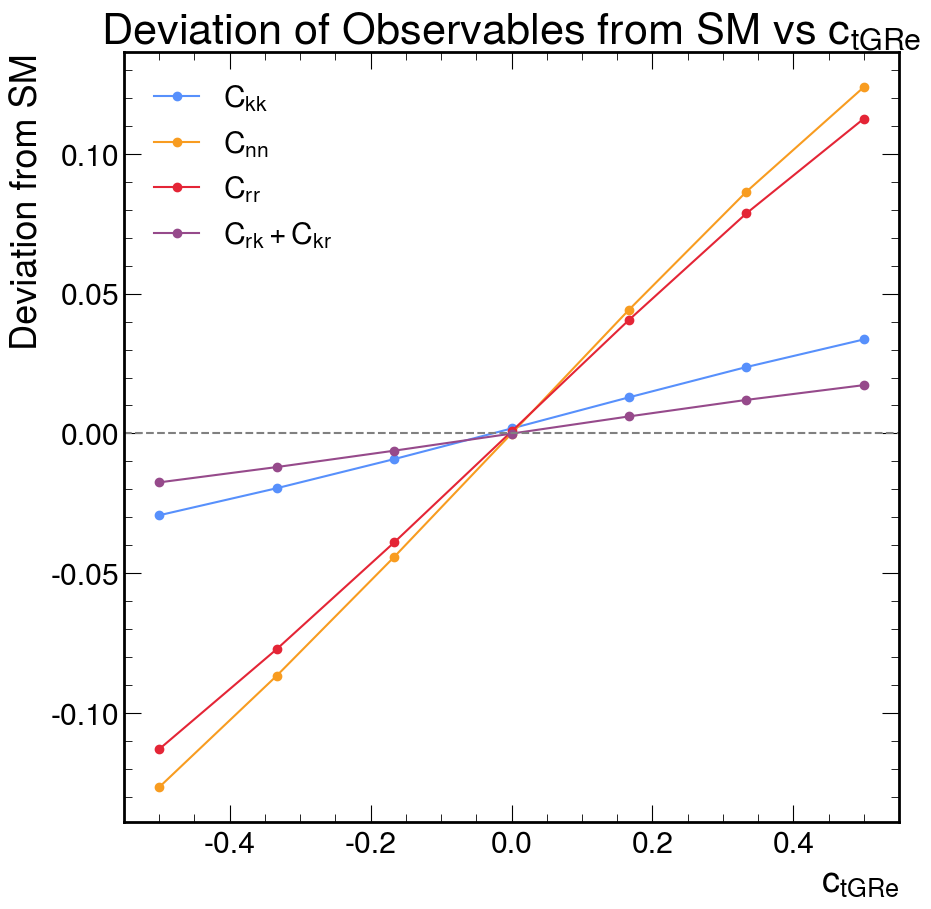

In [79]:
# Step 2: Save Results (Optional)
np.save('deviations.npy', deviations_dict)  # Save deviations as a NumPy file

# Step 3: Load and Plot Results
fig, ax = plt.subplots()

for obs_name, deviations in deviations_dict.items():
    ax.plot(ctGRe_values, deviations, marker='o', label=obs_name)

ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel(r'$c_{tGRe}$')
ax.set_ylabel('Deviation from SM')
ax.set_title('Deviation of Observables from SM vs $c_{tGRe}$')
ax.legend()
plt.show()

In [65]:
import sys
import numpy as np
import uncertainties.unumpy as unp  # Import uncertainties for handling values with errors
home_dir = '/depot/cms/top/jduarteq/top-spincorr-framework/src'
sys.path.insert(0, home_dir)
from entanglement_analysis import steering_utils
from entanglement_analysis import steering_analysis as steering

# Define function to calculate steerability using nominal values
def calculate_steerability(data):
    """Compute steerability using the correlation matrix built from given parameter values."""
    # Extract nominal values for each observable (ignoring uncertainties)
    ckk = unp.nominal_values(data['$C_{kk}$']['parameter value'])
    crr = unp.nominal_values(data['$C_{rr}$']['parameter value'])
    cnn = unp.nominal_values(data['$C_{nn}$']['parameter value'])
    
    # Create correlation matrix
    CC = np.array([[ckk, 0, 0], [0, cnn, 0], [0, 0, crr]])
    
    # Compute steerability using the steerability_condition method
    steerability = steering.steerability_condition(CC, math_module=np) / (2 * np.pi)
    return steerability

# Calculate steerability using provided values
steerability_sm = calculate_steerability(asymmetry_results)

# Print results
print(f"Steerability for SM (ctGRe = 0): {steerability_sm}")


Steerability for SM (ctGRe = 0): 0.43651189756233866


In [19]:
len(weight_sm)

2737422